<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [7]:
#@title Current Date
Today = '2021-09-18' #@param {type:"date"}


# **Introduction**

In [23]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20160984" #@param {type:"string"}
Student_full_name = "Carlos Santiago" #@param {type:"string"}
#@markdown ---

In [24]:
#@title Notebook information
Notebook_type = 'Etivity' #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = 'Draft' #@param ["Draft", "Final"] {type:"raw"}
Submission = True #@param {type:"boolean"}

<b>Explanation of the problem</b>

The first goal is to solve a classification problem of digits 0 to 9 from MNIST dataset. The sample data contains 10 classes of images of 28x28 pixels each.

The classification must be solved with **General-recipe multinomial logist regression** and **Bayesian multinomial logistic regression**. 

The main advantage of **Bayesian multinomial LR** is that it provides a confidence interval (or uncertainty) of the value, which is closer to reality. **General-recipe LR**, on the other hand, gives a single point.

The second goal is to use the posterior uncertainty to detect the digits that are harder to classify and remove them from the dataset. Then we re-run the general-receipe LR and compare the results. 




## MNIST dataset



The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


## Libraries

In [25]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [26]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [27]:
# Setting a seed:
np.random.seed(123)

## Dataset

### Loading the MNIST dataset

COMMENT: The dataset of handwritten digits that has 10 classes of image of 28×28 pixels. Therefore, it inputn has 784 features.

In [28]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [29]:
Path = '/content/drive/MyDrive/etivity-1/'

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'

# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values


In [30]:
# Print shapes of the data

print ("SHAPE OF THE DATA")
print("Training set: ", X_train.shape)
print("Testing set: ", X_test.shape)

SHAPE OF THE DATA
Training set:  (60000, 784)
Testing set:  (10000, 784)


In [31]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Text(0.5, 1.0, 'One sample of each handwritten digit')

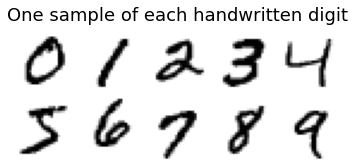

In [32]:
# initialize a null list for distinct digits

distinct_labels = []
sample_vector = []
for x in range(len(y_train)):
  if y_train[x] not in distinct_labels: 
    distinct_labels.append(y_train[x])
    sample_vector.append(X_train[x])

Z = [x for _,x in sorted(zip(distinct_labels,sample_vector))] # Sort sample vector based on ordered labels

# Plotting 'original' image
plt.figure(figsize=(6,6))
plot_digits(Z ,images_per_row=5)
plt.title("One sample of each handwritten digit", fontsize=18)

COMMENT: All features in the dataset have the same importance and should have the same influence on the results. Therefore, we have to normalize the data to give all features the same range. In this case, we will set the range from 0 to 1.

(Jaitley, 2018) has a good article on the importance of Data Normalization

In [33]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [34]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Shape of an traffic sign image
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)
print("% Training set = ", n_train/(n_train+n_test))
print("% Testing set = ", n_test/(n_train+n_test))

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10
% Training set =  0.8571428571428571
% Testing set =  0.14285714285714285


### Class Distribution:

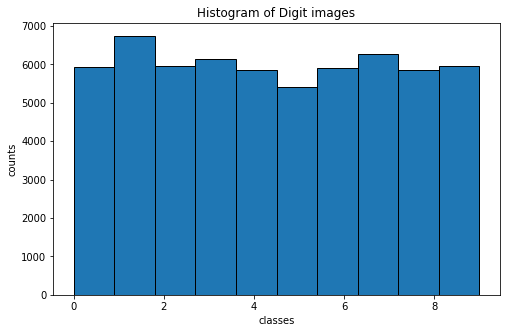

In [35]:
fig, ax = plt.subplots(figsize=(8,5))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()


COMMENT: The sample data has 60k training data and 10k testing data. <br>
Training data accounts for 85.7% of the data set.<br>
We can see from the *Histogram of Digit images* above that the sample data is well distributed across all 10 classes.

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [36]:
# We select the number of Classes we want:
n_classes = 3

# Empty list to append the random digit classes we select:
classes = []

# We select 3 digits at random and make sure they are unique:
while len(classes) < 3:
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    # Append the digit if it's not already in our list of classes:
    if num2choose not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()
# print classes selected
classes

[1, 2, 6]

In [37]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1500

inputs=[]
labels=[]
# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)


New Classes Distribution

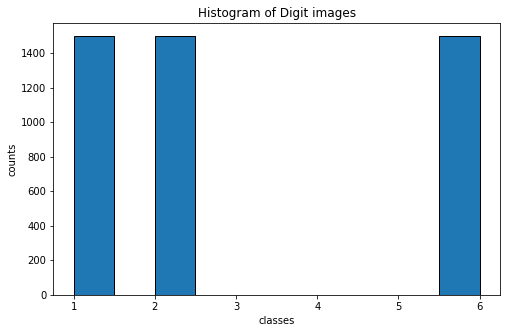

In [38]:
# new histogram
# Exactly same histogram of above

fig, ax = plt.subplots(figsize=(8,5))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, ec='black', align='mid')
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()



COMMENT: We have now a training sample containing three classes only. Each class has 1,500 records, down from the original data set containining 5,800-6,800 instances of each digit (class). This will reduce the computational time.

### Plot training data

Text(0.5, 1.0, '90 random digit images of [1, 2, 6]')

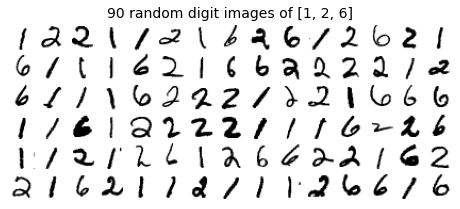

In [39]:
# Show a few instances from each Digit:
plt.figure(figsize=(8,8))

# Selecting a few label indices from each of the 3 classes to show:

randomlist = random.sample(range(0, len(X_train)), 90)  # Generate 90 images, 15 per now 

# Plotting 'original' image
plot_digits(X_train[randomlist,:],images_per_row=15)
plt.title("90 random digit images of "+str(classes), fontsize=14)

###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [40]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [41]:
# print shape of your validation and training set

print("SHAPES OF TRAINING AND VALIDATION SETS\n")
print("Shape of X training set: ",X_train.shape)
print("Shape of X validation set: ",X_val.shape)
print("Shape of Y training set: ",y_train.shape)
print("Shape of Y validation set: ",y_val.shape)


SHAPES OF TRAINING AND VALIDATION SETS

Shape of X training set:  (3600, 784)
Shape of X validation set:  (900, 784)
Shape of Y training set:  (3600,)
Shape of Y validation set:  (900,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

In [42]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_train, y_train)

# Classification:
y_pred_log = model_log.predict(X_val)
y_pred_logi_prob = model_log.predict_proba(X_val)

# Maybe taking the maximum probability 
prob_classmax = np.max(y_pred_logi_prob,axis=1)
# in any of the classes for each observation

# Categories
classes = model_log.classes_
print("Input data are classified into three categories:",classes)

# Computing the Accuracy:
print("Accuracy=", accuracy_score(y_pred_log,y_val))
print("Misclassifications", len(prob_classmax[y_pred_log!=y_val]),"out of",len(X_val),"instances")


Input data are classified into three categories: [1. 2. 6.]
Accuracy= 0.9766666666666667
Misclassifications 21 out of 900 instances


### **Hardest and Easiest images to classify**

Text(0.5, 1.0, 'Hardest image to classify\nLabel: 2')

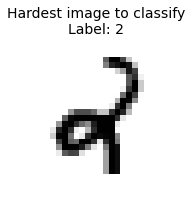

In [43]:
#Plot image hardest to recognise

hardest_label=int(y_train[np.array([np.argmin(prob_classmax)])])
plt.figure(figsize=(3,3))
plot_digits(X_train[np.array([np.argmin(prob_classmax)]),:])
plt.title("Hardest image to classify\nLabel: " + str(hardest_label), fontsize=14)

Text(0.5, 1.0, 'Easiest image to classify\nLabel: 6')

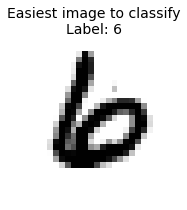

In [44]:
#Plot image easiest to recognise
easiest_label= int(y_train[np.array([np.argmax(prob_classmax)])])
plt.figure(figsize=(3,3))
plot_digits(X_train[np.array([np.argmax(prob_classmax)]),:])
plt.title("Easiest image to classify\nLabel: " + str(easiest_label), fontsize=14)

### Model Performance

Classification evaluation is nicely explained in the blog *How to Use ROC Curves and Precision-Recall Curves for Classification in Python*

Main metrics:

**Precision** = True Positives / (True Positives + False Positives)

**Recall** = True Positives / (True Positives + False Negatives)

**F1-score** = Calculates the harmonic mean of the precision and recall

**Support** = actual occurrences of the class in the specified dataset

The blog Understanding a Classification Report For Your Machine Learning Model
(Kohli, 2019) explains the **classification report** in details.


The below section evaluates the performance of the classifier on each individual class using classification report from *sklearn*

In [45]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

y_true = y_val
y_pred = y_pred_log

target_names = []
for x in classes:
  target_names.append("digit "+str(int(x)))

print(classification_report(y_true, y_pred, target_names=target_names, digits=4))


              precision    recall  f1-score   support

     digit 1     0.9834    0.9867    0.9851       301
     digit 2     0.9736    0.9578    0.9656       308
     digit 6     0.9729    0.9863    0.9795       291

    accuracy                         0.9767       900
   macro avg     0.9766    0.9769    0.9767       900
weighted avg     0.9767    0.9767    0.9766       900



### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [46]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_train.reshape(-1,1))
nf = X_train.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_train,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)

In [47]:
with multi_logistic:
   approx = pm.fit(5000, method='advi')


WARNING (theano.tensor.blas): We did not find a dynamic library in the library_dir of the library we use for blas. If you use ATLAS, make sure to compile it with dynamics library.


Finished [100%]: Average Loss = 8,424.3


Text(0.5, 0, '# iterations')

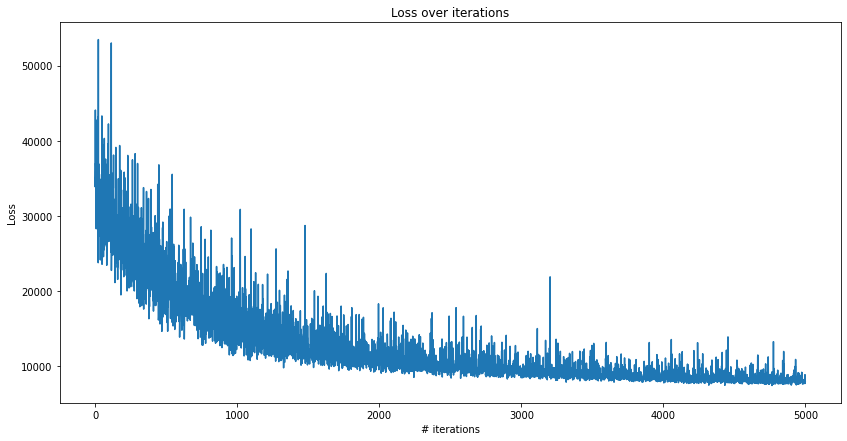

In [48]:
# Plot the average loss over all iterations
plt.rcParams['figure.figsize'] = [14,7] # Set figure size
plt.plot(approx.hist)
plt.title('Loss over iterations')
plt.ylabel("Loss")
plt.xlabel("# iterations")

In [49]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 2.0
classes: [1. 2. 6.]
estimated prob= [0. 1. 0.]


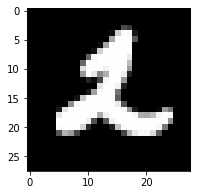

In [50]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax
from keras.preprocessing import image

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
image = X_val[i,:].reshape(28,28) # Image shape is 28x28 = 784

plt.figure(figsize=(3,3))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

In [51]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_val.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_val[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


In [52]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.95


## Selecting different instances


In [53]:
y_predB=[]

for i in range(X_val.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_val[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [54]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.99988869, 0.        ],
       [1.        , 0.99946568, 0.        ],
       [1.        , 0.99572311, 0.05763872],
       [2.        , 0.76112686, 0.40730824],
       [1.        , 0.98793817, 0.11469767],
       [1.        , 0.56526066, 0.49638695],
       [0.        , 0.99137805, 0.05763872],
       [0.        , 0.97522098, 0.1280191 ],
       [0.        , 0.97353395, 0.1280191 ],
       [0.        , 0.95210834, 0.19595918]])

In [55]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[0.        , 0.49926324, 0.5       ],
       [1.        , 0.50259462, 0.49998889],
       [2.        , 0.49354243, 0.49995555],
       [1.        , 0.48683361, 0.49995555],
       [0.        , 0.49807912, 0.49989999],
       [1.        , 0.51110886, 0.49972215],
       [2.        , 0.4708998 , 0.49959984],
       [0.        , 0.53554493, 0.49959984],
       [2.        , 0.5093782 , 0.49945526],
       [1.        , 0.53180009, 0.49945526]])

In [56]:
y_predB[y_pred_log != y_val,:]

array([[1.        , 0.56526066, 0.49638695],
       [1.        , 0.84086466, 0.35707142],
       [1.        , 0.9652969 , 0.17058722],
       [1.        , 0.57723815, 0.49243161],
       [0.        , 0.61597404, 0.48368952],
       [1.        , 0.94282325, 0.22469733],
       [0.        , 0.80354508, 0.38138636],
       [1.        , 0.82930683, 0.36660606],
       [1.        , 0.87427804, 0.32881944],
       [2.        , 0.78907797, 0.40491426],
       [1.        , 0.85519367, 0.34349511],
       [2.        , 0.52384578, 0.49781746],
       [2.        , 0.61122149, 0.48189441],
       [2.        , 0.9962096 , 0.        ],
       [1.        , 0.53587409, 0.49811868],
       [1.        , 0.53134936, 0.49839743],
       [1.        , 0.60929731, 0.48848974],
       [1.        , 0.67700639, 0.46110977],
       [2.        , 0.99989342, 0.        ],
       [1.        , 0.51110886, 0.49972215],
       [0.        , 0.76618953, 0.40730824]])

In [57]:
## Difficult & easy instances

print("Accuracy in all instances =", accuracy_score(y_pred_log, y_val))

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_log[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_log[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in all instances = 0.9766666666666667
Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.9


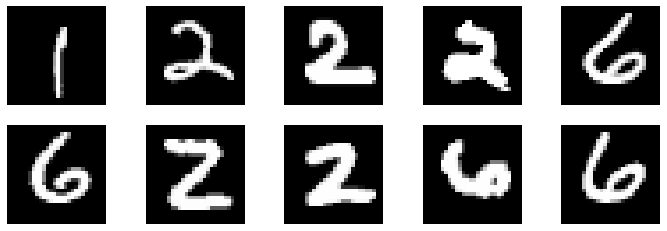

In [58]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(12, 4))
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

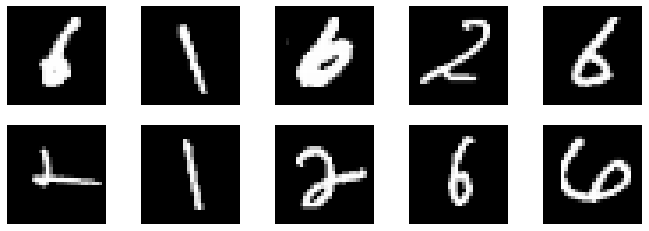

In [59]:
# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(12, 4))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    image = X_val[index,:].reshape(28,28)
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

**Remove the most difficult instances from General recipe ML**

**Method**

The accuracy of General recipe ML is around 96% meaning that less than 5% of the predictions are misclassified.

My approach here is to exclude a percentage (xpc in the code) hardest images to classify. This should increase the performance very significantly.  


In [66]:
# difficult = np.argsort(-y_predB[:,2])

xpc = 0.05 # x% of hardest images to exclude from the retrain data set.
exclusions = int(len(X_val)*xpc) # Calculate 5% of the sample data

hardest=(difficult[0:exclusions]) # Get the list of the 5% hardest images to classify

X_recompute=[] # List X_val to retrain
y_recompute=[] # List y_val to retrain

for i in range(len(X_val)):  # Exclude the 5% hardest to classify
  if i not in (hardest):
    X_recompute.append(X_val[i])
    y_recompute.append(y_val[i])
    

len(X_recompute) # Total of instances to retrain


855

In [67]:
# model
model_logi_recomputed = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_recompute, y_recompute)

# Classification
y_pred_logi_recomputed = model_logi_recomputed.predict(X_val)
y_pred_logi_prob_recomputed = model_logi_recomputed.predict_proba(X_val)

prob_classmax_recomputed = np.max(y_pred_logi_prob_recomputed,axis=1)

**Compare the accuracy**

In [68]:
# Computing the Accuracy of Original Model:
print('Original Model')
print('Accuracy=', accuracy_score(y_pred_log,y_val))
print("Misclassifications", len(prob_classmax[y_pred_log!=y_val]))

print('\n')
print('Re-computed model removing the',str(xpc * 100),'% hardest instances')
print('Accuracy=', accuracy_score(y_pred_logi_recomputed,y_val))
print("Misclassifications", len(prob_classmax[y_pred_logi_recomputed!=y_val]))

Original Model
Accuracy= 0.9766666666666667
Misclassifications 21


Re-computed model removing the 5.0 % hardest instances
Accuracy= 0.9877777777777778
Misclassifications 11


## Summary

**Dataset**

The MNIST dataset of handwritten digits is great. 60K of training & 10k of testing data are enough for, at least, learning purposes. I didn't find any cons of the dataset.

**Work completed**

* The dataset was loaded and one instance of each handwritten digit was plotted to enable us to get a feel for what the dataset looked like.
* The data was normalized to reduce it to a common scale between 0 and 1. I also included some explanations of the relevance of this task. 
* The data was described: sample size, shape, proportion of training and testing data and, plot of histogram
* The dataset was downsampled to 1,500 instances of 3 random classes. The distribution is shown on a histogram. The classes randomly chosen are 1,2 and 6.
* 90 random instances of the downsampled data set were plotted. 
* the data set was split: 80% training and 20% testing. The new shapes were printed out.
* A General Recipe Multinomial LR was trained
* Classes of the testing set were predicted and both the accuracy of 97.7% and number of misclassifications (21 out of 900) were printed out.
* The hardest and easiest images to classify were plotted to get a feel for what they looked like. 
* The model was evaluated using classification report from *sklearn*. It printed out the **precision, recall, F1-Score **and **Support** of each classe. I also included an explanation of each metric along with the references to an article.    
* A Probabilistic Multinomial LR was trained on training set and the classes of the testing set were predicted. The accuracy of 95% was printed out. 
* The hardest image to classify was plotted as well as 10 random images from the list of hard and 10 from the list of easy.
* Posterior uncertainty was used to detect the instances in the test set that are hard to classify. The 5% hardest were removed from the test-set. 
* The General Recipe Multinomial LR model was re-computed without the hardest images and the new accuracy of 98.7% was printed out along with number of 10 misclassifications. 


**Discussions with my peers**

The discussion on the forums were very useful. We reviewed each others' solutions, learned from our peers and received/gave feedback.
I've learned from the discussions that the main advantage of Bayesian multinomial LR is that it provides a confidence interval (or uncertainty) of the value, which is closer to reality. General-recipe LR, on the other hand, gives a single point.
There are many discussion in the forums related to approaches to draw a boundary between easy and hard images to classify. However, everyone seems to agree that any decisons would rely on the de definition of hard/easy, sample size, algorithm used, parameters applied etc. so it really depends on the specific problem to solve and the tools available. I decided to simply use the posterior uncertainty to detect the instances (digits) in the test set that are harder to classify and removed the 5% hardest ones to classify from the test-set and shared my approach with my peers. Feedback were positive encouraging me to stick with this approach. 


**Conclusions about the e-tivity**

E-tivity 1 was very interesting and I've learned a lot from the resources, discussions and my peers' solutions. It would worth to further explore differents sets of samples and predictions with more than 3 classes.  

## References


1) Brownlee, J., 2018. How to Use ROC Curves and Precision-Recall Curves for Classification in Python. [online] Machine Learning Mastery. Available at: <https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/> [Accessed 15 September 2021].

2) Jaitley, U., 2018. Why Data Normalization is necessary for Machine Learning models. [online] Medium. Available at: <https://medium.com/@urvashilluniya/why-data-normalization-is-necessary-for-machine-learning-models-681b65a05029> [Accessed 15 September 2021].

3) Kohli, S., 2019. Understanding a Classification Report For Your Machine Learning Model. [online] Medium. Available at: <https://medium.com/@kohlishivam5522/understanding-a-classification-report-for-your-machine-learning-model-88815e2ce397> [Accessed 15 September 2021].